# Data Preparation

## Imports

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

ImportError: cannot import name 'mean_absolute_percentage_error' from 'sklearn.metrics' (C:\Users\ang24\anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [48]:
def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):
    """Mean absolute percentage error regression loss.
    Note here that we do not represent the output as a percentage in range
    [0, 100]. Instead, we represent it in range [0, 1/eps]. Read more in the
    :ref:`User Guide <mean_absolute_percentage_error>`.
    .. versionadded:: 0.24
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    multioutput : {'raw_values', 'uniform_average'} or array-like
        Defines aggregating of multiple output values.
        Array-like value defines weights used to average errors.
        If input is list then the shape must be (n_outputs,).
        'raw_values' :
            Returns a full set of errors in case of multioutput input.
        'uniform_average' :
            Errors of all outputs are averaged with uniform weight.
    Returns
    -------
    loss : float or ndarray of floats in the range [0, 1/eps]
        If multioutput is 'raw_values', then mean absolute percentage error
        is returned for each output separately.
        If multioutput is 'uniform_average' or an ndarray of weights, then the
        weighted average of all output errors is returned.
        MAPE output is non-negative floating point. The best value is 0.0.
        But note the fact that bad predictions can lead to arbitarily large
        MAPE values, especially if some y_true values are very close to zero.
        Note that we return a large value instead of `inf` when y_true is zero.
    Examples
    --------
    >>> from sklearn.metrics import mean_absolute_percentage_error
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    0.3273...
    >>> y_true = [[0.5, 1], [-1, 1], [7, -6]]
    >>> y_pred = [[0, 2], [-1, 2], [8, -5]]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    0.5515...
    >>> mean_absolute_percentage_error(y_true, y_pred, multioutput=[0.3, 0.7])
    0.6198...
    """
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
        y_true, y_pred, multioutput)
    check_consistent_length(y_true, y_pred, sample_weight)
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

In [3]:
df = pd.read_csv('Data/vehicles.csv')

## Data Exploration

In [3]:
df.head()

NameError: name 'df' is not defined

In [4]:
df.columns

NameError: name 'df' is not defined

In [5]:
df.shape

NameError: name 'df' is not defined

<BarContainer object of 43 artists>

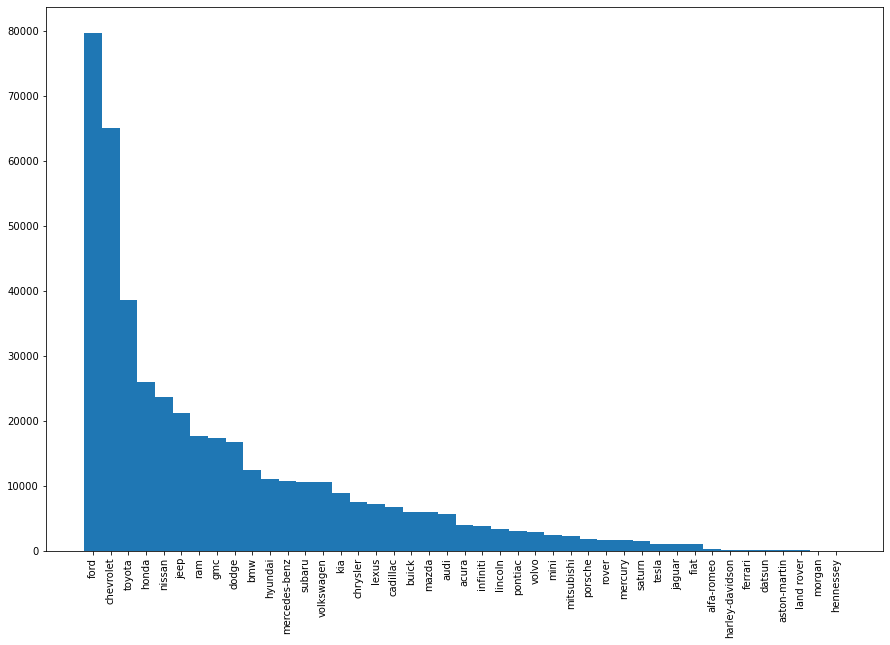

In [4]:
x = (df.groupby(['manufacturer'],as_index = False).count().sort_values('price', ascending = False))['manufacturer'].tolist()
y = (df.groupby(['manufacturer'],as_index = False).count().sort_values('price', ascending = False))['price'].tolist()
fig = plt.figure(figsize=(15,10))
plt.xticks(rotation = 90)
plt.bar(x, y, width=1)

In [5]:
#Information about the categorical variables

print(df["paint_color"].unique())
print(df["condition"].unique())
print(df["type"].unique())
print(df["fuel"].unique())
print(df["cylinders"].unique())
print(df["title_status"].unique())
print(df["type"].unique())
print(df["drive"].unique())
print(df["transmission"].unique())

[nan 'blue' 'red' 'silver' 'black' 'white' 'grey' 'orange' 'green'
 'yellow' 'custom' 'brown' 'purple']
['good' 'excellent' nan 'like new' 'fair' 'salvage' 'new']
['other' 'sedan' 'SUV' 'pickup' 'coupe' 'van' nan 'truck' 'mini-van'
 'wagon' 'convertible' 'hatchback' 'bus' 'offroad']
['gas' 'diesel' 'other' 'hybrid' nan 'electric']
['8 cylinders' '4 cylinders' '6 cylinders' nan '10 cylinders' 'other'
 '5 cylinders' '3 cylinders' '12 cylinders']
['clean' 'lien' 'missing' 'salvage' 'rebuilt' nan 'parts only']
['other' 'sedan' 'SUV' 'pickup' 'coupe' 'van' nan 'truck' 'mini-van'
 'wagon' 'convertible' 'hatchback' 'bus' 'offroad']
['rwd' 'fwd' nan '4wd']
['other' 'automatic' 'manual' nan]


In [6]:
df.isnull().sum().sort_values(ascending = False)

size            321348
condition       192940
VIN             187549
cylinders       171140
paint_color     140843
drive           134188
type            112738
odometer         55303
manufacturer     18220
lat               7448
long              7448
model             4846
fuel              3237
title_status      2577
transmission      2442
year              1050
description         70
posting_date        28
image_url           28
state                0
price                0
region_url           0
region               0
url                  0
id                   0
Unnamed: 0           0
dtype: int64

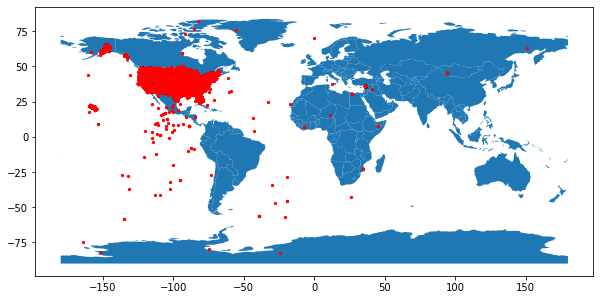

In [7]:
#a lot of locations that don't make sense (i.e. on Antarctica or in the ocean) 
#User can drop a pin anywhere in the world => lat & long values are unreliable
#Use 'state' and/or 'region' instead of lat & long for location

geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);

## Data Cleaning

### Dropping columns/instances

In [8]:
#drop columns that don't add any value to our analysis

df.drop(['Unnamed: 0', 'id', 'url', 'region_url', 'lat', 'long', 'VIN', 'image_url',
         'description', 'geometry', 'posting_date'], axis = 1, inplace = True)
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,auburn,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,rwd,NaN,other,NaN,al
1,auburn,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,fwd,NaN,sedan,NaN,al
2,auburn,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,SUV,blue,al
3,auburn,2000,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,rwd,full-size,pickup,blue,al
4,auburn,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,4wd,full-size,pickup,blue,al


In [9]:
df.shape

(458213, 16)

In [10]:
#keep only 'clean' cars & missing values
#missing, parts only, etc. cars don't fit the goal of our analysis

df = df[((df['title_status'] != 'missing') & (df['title_status'] != 'parts only') 
    & (df['title_status'] != 'salvage') & (df['title_status'] != 'rebuilt')
   & (df['title_status'] != 'lien'))]
df.shape

(442203, 16)

In [11]:
#delete unrealistically over-/underpriced cars (over $500k or under $100)
#sometimes prices are $0 or $123456789 because the owner wants to agree on the price in person

df = df[((df['price'] < 500000) & (df['price'] > 100))]
df.shape

(405701, 16)

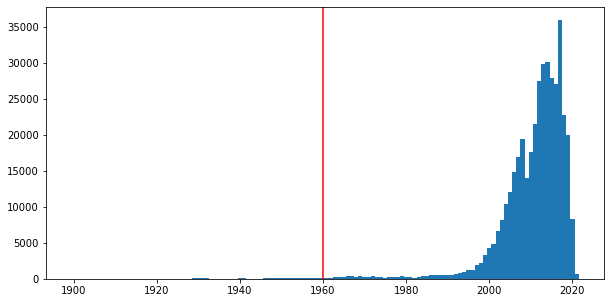

In [12]:
starting_year = 1960
x = (df.groupby(['year'],as_index = False).count())['year'].tolist()
y = (df.groupby(['year'],as_index = False).count())['price'].tolist()
fig = plt.figure(figsize=(10,5))
plt.bar(x, y, width=1)
plt.axvline(starting_year, color = 'red')

In [13]:
#delete cars built before 1960 (outliers)

df = df[df['year'] > 1960]
df.shape

(402751, 16)

In [14]:
#delete top 1% of odometer values (outliers)

top1 = np.nanpercentile(df['odometer'], 99)
print('the top 1% mileage is', top1, 'miles')
df = df[df['odometer'] < top1]
df.shape

the top 1% mileage is 272000.0 miles


(354615, 16)

In [15]:
#size is perfect multicollinear with car model => drop size column

df.drop('size', axis = 1, inplace = True)
df.shape

(354615, 15)

In [16]:
#delete unknown fuel, transmission and title_status instances

df.dropna(subset = ['fuel', 'transmission', 'title_status'], axis = 0, inplace = True)
df.shape

(349990, 15)

In [17]:
#delete all instances with unknown manufacturer

df = df[~df['manufacturer'].isnull()]
df.shape

(340030, 15)

In [18]:
#delete all instances with unknown model

df = df[~df['model'].isnull()]
df.shape

(337757, 15)

### Replacing missing values with placeholders 

In [20]:
#replace missing condition values with 'not specified'

df['condition'].fillna('not specified', inplace = True)
df['condition'].unique()

array(['good', 'excellent', 'not specified', 'like new', 'new', 'salvage',
       'fair'], dtype=object)

In [21]:
#replace missing color with 'unknown'

df['paint_color'].fillna('unknown', inplace = True)
df['paint_color'].unique()

array(['unknown', 'blue', 'red', 'silver', 'black', 'white', 'grey',
       'orange', 'green', 'custom', 'yellow', 'brown', 'purple'],
      dtype=object)

### Cleaning car model values and reducing the number of categories

In [24]:
#first word is most important for 'model': many car model categories refer to the same model but are written differently 
#(i.e. 'f150 good condition' and 'F - 150 four wheel drive' refer to the same model: f150)
#=> keep only first word and remove spaces, special characters, uppercase letters, etc.

#delete instances with a model that appears less than 150 times => reduce amount of categories by omitting uncommon types

model_list = df['model'].tolist()
model_list = map(str, model_list)
model_list = [x.lower().strip() for x in model_list]
my_list = [car_model.split()[0] for car_model in model_list]
my_list = [x.replace(' ', '').replace('-', '').replace('/', '') for x in my_list]

df['car_model'] = my_list
df['car_model'] = df['manufacturer'] + " " + df['car_model']

new_car_models = (df.groupby(['car_model'], as_index= False).count())[['manufacturer', 'car_model', 'price']]
new_car_models = new_car_models.rename(columns={'price': 'count'})
only_common_models = new_car_models[new_car_models['count'] > 150]

print('total car models: ', len(new_car_models['count']))
print('remaining car models: ', len(only_common_models['count']))
print('decreasing ', round((1-len(only_common_models['count'])/len(new_car_models['count'])) * 100, 2),'% of the number of car models')
print()
print('total instances: ', len(df['price']))
print('remaining instances: ', sum(only_common_models['count']))
print('removing ', round((1-sum(only_common_models['count'])/len(df['price'])) * 100, 2),'% of the instances')

total car models:  2803
remaining car models:  292
decreasing  89.58 % of the number of car models

total instances:  337757
remaining instances:  309211
removing  8.45 % of the instances


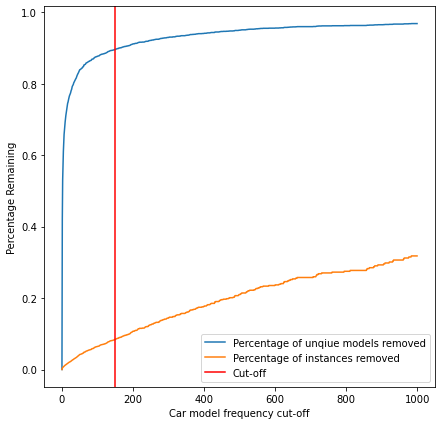

In [25]:
#150 seems like the reasonable choice w.r.t. trade-off reducing categories vs keeping enough data

removed_models_list = []
removed_instances_list = []

for i in range(0,1000):
    only_common_models_v2 = new_car_models[new_car_models['count']>i]
    models_removed = 1-len(only_common_models_v2['count'])/len(new_car_models['count'])
    instances_removed = 1-sum(only_common_models_v2['count'])/len(df['price'])
    
    removed_models_list.append(models_removed)
    removed_instances_list.append(instances_removed)

fig = plt.figure(figsize=(7,7))
plt.plot(removed_models_list, label = 'Percentage of unqiue models removed')
plt.plot(removed_instances_list, label = 'Percentage of instances removed')
plt.axvline(150 , color = 'red', label = 'Cut-off')
plt.ylabel('Percentage Remaining')
plt.xlabel('Car model frequency cut-off')
plt.legend()

In [28]:
#committing car model cleaning to original dataframe

df = df[df['car_model'].isin(only_common_models['car_model'].tolist())]
df.drop('model', axis = 1, inplace = True)
df.shape

KeyError: "['model'] not found in axis"

In [29]:
df.head()

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,car_model
0,auburn,35990,2010.0,chevrolet,good,8 cylinders,gas,32742.0,clean,other,rwd,other,unknown,al,chevrolet corvette
1,auburn,7500,2014.0,hyundai,excellent,4 cylinders,gas,93600.0,clean,automatic,fwd,sedan,unknown,al,hyundai sonata
2,auburn,4900,2006.0,bmw,good,6 cylinders,gas,87046.0,clean,automatic,NaN,SUV,blue,al,bmw x3
5,auburn,29590,2016.0,toyota,good,6 cylinders,gas,33290.0,clean,other,NaN,pickup,red,al,toyota tacoma
6,auburn,39990,2012.0,ford,good,8 cylinders,gas,9692.0,clean,other,rwd,coupe,blue,al,ford mustang


### Replacing missing values with reasonable proxies

In [30]:
#replace missing number of cylinders with median of car model & delete 'other'

df = df[df['cylinders'] != 'other']
dftest = df.copy()
test = df[df['cylinders'].notnull()].copy()
test['cylinders'] = [int(cyl.split()[0]) for cyl in test['cylinders']]
med = test.groupby('car_model')['cylinders'].median()
merged = pd.merge(dftest, med, on = 'car_model', how = 'left')
merged['cylinders_y'].fillna(med.median(), inplace = True)
merged['cylinders_x'].fillna(merged['cylinders_y'], inplace = True)

li = []
for cyl in merged['cylinders_x']:
    if type(cyl) == str:
        li.append(cyl)
    else:
        li.append(str(int(cyl)) + " cylinders")

df['cylinders'] = li
df['cylinders'].unique()

<ipython-input-30-61fb40e5a7cb>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cylinders'] = li


array(['8 cylinders', '4 cylinders', '6 cylinders', '10 cylinders',
       '5 cylinders', '3 cylinders', '7 cylinders', '12 cylinders'],
      dtype=object)

In [31]:
#replace drive with mode drive of car model

dftest = df.copy()
test = df[df['drive'].notnull()].copy()
mode = test.groupby('car_model')['drive'].agg(pd.Series.mode)
merged = pd.merge(dftest, mode, on = 'car_model', how = 'left')
merged['drive_x'].fillna(merged['drive_y'], inplace = True)

df['drive'] = merged['drive_x'].tolist()
df['drive'].unique()

<ipython-input-31-a5ca647b7fc4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['drive'] = merged['drive_x'].tolist()


array(['rwd', 'fwd', '4wd'], dtype=object)

In [32]:
#replace type with mode type of car model

dftest = df.copy()
test = df[df['type'].notnull()].copy()
mode = test.groupby('car_model')['type'].agg(pd.Series.mode)
for i in mode.index:
    if type(mode[i]) != str:
        mode[i] = mode[i][0]
merged = pd.merge(dftest, mode, on = 'car_model', how = 'left')
merged['type_x'].fillna(merged['type_y'], inplace = True)

df['type'] = merged['type_x'].tolist()
df['type'].unique()

<ipython-input-32-28df1ba0a29f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = merged['type_x'].tolist()


array(['other', 'sedan', 'SUV', 'pickup', 'coupe', 'van', 'mini-van',
       'wagon', 'convertible', 'hatchback', 'truck', 'offroad', 'bus'],
      dtype=object)

In [33]:
#all the missing values are handled

df.isnull().sum()

region          0
price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
car_model       0
dtype: int64

### Handling price outliers

In [34]:
#get rid of overpriced cars: overpriced = more than 3 times the average for this model

df = df[df['price'] < (3 * df.groupby('car_model')['price'].transform('mean'))]
df.shape

(307422, 15)

### Dropping columns with redundant information

In [36]:
#get rid of 'title_status' since it is 'clean' for every instance

df.drop('title_status', axis = 1, inplace = True)
df.shape

KeyError: "['title_status'] not found in axis"

In [37]:
#region & state contain same information (certain region is always in the same state)

df.drop('region', axis = 1, inplace = True)
df.shape

(307422, 13)

### Making a backup and saving the data

In [38]:
clean = df.copy()

In [39]:
df.to_csv('clean.csv', index = False)

## Feature Engineering/Selection

### Creating modeling and k-fold cross validation functions

In [40]:
#creates model as defined in 'reg' and returns test & train evaluation metrics
#default is 80/20 train-test split: industry standard

def updateModel(datafr, test_percentage = 0.2, seed = 7):
    
    #train-test split
    X = datafr.drop('price', axis = 1)
    y = datafr['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_percentage, random_state = seed)
    X_train = pd.get_dummies(X_train, drop_first = True)
    X_test = pd.get_dummies(X_test, drop_first = True)
    
    #feature scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    #making model + predicting
    reg.fit(X_train, y_train)
    y_pred_test = reg.predict(X_test)
    y_pred_train = reg.predict(X_train)
    
    #computing test & train metrics
    test_metrics = {'r2': round(r2_score(y_test, y_pred_test) * 100, 2),
           'mae': round(mean_absolute_error(y_test, y_pred_test), 2),
           'mse': round(mean_squared_error(y_test, y_pred_test), 2),
           'mape': round(mean_absolute_percentage_error(y_test, y_pred_test) * 100, 2)
           }
    train_metrics = {'r2': round(r2_score(y_train, y_pred_train) * 100, 2),
           'mae': round(mean_absolute_error(y_train, y_pred_train), 2),
           'mse': round(mean_squared_error(y_train, y_pred_train), 2),
           'mape': round(mean_absolute_percentage_error(y_train, y_pred_train) * 100, 2)
           }
    
    return {'test_metrics': test_metrics,
            'train_metrics': train_metrics}

In [41]:
#creates model as defined in 'reg' and returns k fold cross validation metrics
#default is 5-fold CV: industry standard & default scoring is MAE because of easy interpretation

def get_kCVscores(datafr, k = 5, scoring = 'neg_mean_absolute_error'):
    X = datafr.drop('price', axis = 1)
    X = pd.get_dummies(X, drop_first = True)
    y = datafr['price']
    return (cross_val_score(reg, X, y, cv = k, scoring = scoring) * (-1))

In [42]:
#K-means clustering function
def k_means_clustering(datafr, k):
    df_to_return = datafr.copy()
    df_with_dummies = pd.get_dummies(datafr, drop_first = True)
    km = KMeans(n_clusters = k)
    df_to_return['cluster'] = km.fit_predict(df_with_dummies)
    
    return df_to_return

### Baseline Linear Regression before feature engineering

In [43]:
reg = LinearRegression()

In [50]:
def _check_reg_targets(y_true, y_pred, multioutput, dtype="numeric"):
    """Check that y_true and y_pred belong to the same regression task.
    Parameters
    ----------
    y_true : array-like
    y_pred : array-like
    multioutput : array-like or string in ['raw_values', uniform_average',
        'variance_weighted'] or None
        None is accepted due to backward compatibility of r2_score().
    Returns
    -------
    type_true : one of {'continuous', continuous-multioutput'}
        The type of the true target data, as output by
        'utils.multiclass.type_of_target'.
    y_true : array-like of shape (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples, n_outputs)
        Estimated target values.
    multioutput : array-like of shape (n_outputs) or string in ['raw_values',
        uniform_average', 'variance_weighted'] or None
        Custom output weights if ``multioutput`` is array-like or
        just the corresponding argument if ``multioutput`` is a
        correct keyword.
    dtype : str or list, default="numeric"
        the dtype argument passed to check_array.
    """
    check_consistent_length(y_true, y_pred)
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)

    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))

    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("y_true and y_pred have different number of output "
                         "({0}!={1})".format(y_true.shape[1], y_pred.shape[1]))

    n_outputs = y_true.shape[1]
    allowed_multioutput_str = ('raw_values', 'uniform_average',
                               'variance_weighted')
    if isinstance(multioutput, str):
        if multioutput not in allowed_multioutput_str:
            raise ValueError("Allowed 'multioutput' string values are {}. "
                             "You provided multioutput={!r}".format(
                                 allowed_multioutput_str,
                                 multioutput))
    elif multioutput is not None:
        multioutput = check_array(multioutput, ensure_2d=False)
        if n_outputs == 1:
            raise ValueError("Custom weights are useful only in "
                             "multi-output cases.")
        elif n_outputs != len(multioutput):
            raise ValueError(("There must be equally many custom weights "
                              "(%d) as outputs (%d).") %
                             (len(multioutput), n_outputs))
    y_type = 'continuous' if n_outputs == 1 else 'continuous-multioutput'

    return y_type, y_true, y_pred, multioutput


In [55]:

from sklearn.utils.validation import (check_array, check_consistent_length,
                                _num_samples)

In [56]:
#initial linear regression model

init_metrics = updateModel(df)
def print_metrics(metrics):
    print('test performance:', metrics['test_metrics'])
    print('initial test performance:', init_metrics['test_metrics'])
    print()
    print('train performance:', metrics['train_metrics'])
    print('initial train performance:', init_metrics['train_metrics'])
    print()
    print('change in test MAE:', round((init_metrics['test_metrics']['mae'] - metrics['test_metrics']['mae']) / 
      (init_metrics['test_metrics']['mae']) * 100, 2), '%')
print_metrics(init_metrics)

test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: 0.0 %


Reasonably poor performance but no sign of overfitting

### Grouping states into North-East, Mid-West, South and West

In [57]:
regions_dict = {"state": ["al","ak","az","ar","ca","co","ct","de","dc","fl","ga","hi","id","il","in","ia","ks","ky","la","me","md","ma","mi","mn","ms","mo","mt","ne","nv","nh","nj","nm","ny","nc","nd","oh","ok","or","pa","ri","sc","sd","tn","tx","ut","vt","va","wa","wv","wi","wy"], 
         "region": ["south","west","west","south","west","west","north-east","south","south","south","south","west","west","mid-west","mid-west","mid-west","mid-west","south","south","north-east","south","north-east","mid-west","mid-west","south","mid-west","west","mid-west","west","north-east","north-east","west","north-east","south","mid-west","mid-west","south","west","north-east","north-east","south","mid-west","south","south","west","north-east","south","west","south","mid-west","west"]}
dfState = pd.merge(df, pd.DataFrame(regions_dict), on = 'state', how = 'left').drop('state', axis = 1)
dfState

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,car_model,region
0,35990,2010.0,chevrolet,good,8 cylinders,gas,32742.0,other,rwd,other,unknown,chevrolet corvette,south
1,7500,2014.0,hyundai,excellent,4 cylinders,gas,93600.0,automatic,fwd,sedan,unknown,hyundai sonata,south
2,4900,2006.0,bmw,good,6 cylinders,gas,87046.0,automatic,4wd,SUV,blue,bmw x3,south
3,29590,2016.0,toyota,good,6 cylinders,gas,33290.0,other,4wd,pickup,red,toyota tacoma,south
4,39990,2012.0,ford,good,8 cylinders,gas,9692.0,other,rwd,coupe,blue,ford mustang,south
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307417,19950,2017.0,audi,not specified,4 cylinders,gas,101270.0,automatic,4wd,sedan,unknown,audi a4,mid-west
307418,14995,2014.0,cadillac,excellent,6 cylinders,gas,83790.0,automatic,4wd,SUV,silver,cadillac srx,mid-west
307419,17895,2018.0,hyundai,excellent,4 cylinders,gas,31888.0,automatic,4wd,SUV,white,hyundai tucson,mid-west
307420,17900,2014.0,cadillac,excellent,6 cylinders,gas,53000.0,automatic,4wd,coupe,black,cadillac cts,west


In [58]:
#new metrics

binned_states_metrics = updateModel(dfState)
print_metrics(binned_states_metrics)

test performance: {'r2': 73.77, 'mae': 4124.68, 'mse': 41658906.34, 'mape': 160.27}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 73.42, 'mae': 4138.17, 'mse': 42394179.58, 'mape': 163.81}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: 0.1 %


almost no difference => let's try just removing region & state altogether

### Dropping 'state' variable

In [59]:
dfDropState = df.drop('state', axis = 1)
dfDropState

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,car_model
0,35990,2010.0,chevrolet,good,8 cylinders,gas,32742.0,other,rwd,other,unknown,chevrolet corvette
1,7500,2014.0,hyundai,excellent,4 cylinders,gas,93600.0,automatic,fwd,sedan,unknown,hyundai sonata
2,4900,2006.0,bmw,good,6 cylinders,gas,87046.0,automatic,4wd,SUV,blue,bmw x3
5,29590,2016.0,toyota,good,6 cylinders,gas,33290.0,other,4wd,pickup,red,toyota tacoma
6,39990,2012.0,ford,good,8 cylinders,gas,9692.0,other,rwd,coupe,blue,ford mustang
...,...,...,...,...,...,...,...,...,...,...,...,...
458207,19950,2017.0,audi,not specified,4 cylinders,gas,101270.0,automatic,4wd,sedan,unknown,audi a4
458208,14995,2014.0,cadillac,excellent,6 cylinders,gas,83790.0,automatic,4wd,SUV,silver,cadillac srx
458209,17895,2018.0,hyundai,excellent,4 cylinders,gas,31888.0,automatic,4wd,SUV,white,hyundai tucson
458210,17900,2014.0,cadillac,excellent,6 cylinders,gas,53000.0,automatic,4wd,coupe,black,cadillac cts


In [60]:
#new metrics

drop_state_metrics = updateModel(dfDropState)
print_metrics(drop_state_metrics)

test performance: {'r2': 73.63, 'mae': 4139.43, 'mse': 41876646.03, 'mape': 159.42}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 73.3, 'mae': 4155.25, 'mse': 42590000.12, 'mape': 162.89}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: -0.26 %


test MAE became (marginally) worse, so let's keep the 'state' feature

### Excluding car_model (many categories)

In [61]:
dfNoCarModel = df.drop('car_model', axis = 1)
dfNoCarModel

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
0,35990,2010.0,chevrolet,good,8 cylinders,gas,32742.0,other,rwd,other,unknown,al
1,7500,2014.0,hyundai,excellent,4 cylinders,gas,93600.0,automatic,fwd,sedan,unknown,al
2,4900,2006.0,bmw,good,6 cylinders,gas,87046.0,automatic,4wd,SUV,blue,al
5,29590,2016.0,toyota,good,6 cylinders,gas,33290.0,other,4wd,pickup,red,al
6,39990,2012.0,ford,good,8 cylinders,gas,9692.0,other,rwd,coupe,blue,al
...,...,...,...,...,...,...,...,...,...,...,...,...
458207,19950,2017.0,audi,not specified,4 cylinders,gas,101270.0,automatic,4wd,sedan,unknown,wi
458208,14995,2014.0,cadillac,excellent,6 cylinders,gas,83790.0,automatic,4wd,SUV,silver,wi
458209,17895,2018.0,hyundai,excellent,4 cylinders,gas,31888.0,automatic,4wd,SUV,white,wi
458210,17900,2014.0,cadillac,excellent,6 cylinders,gas,53000.0,automatic,4wd,coupe,black,wy


In [62]:
no_car_model_metrics = updateModel(dfNoCarModel)
print_metrics(no_car_model_metrics)

test performance: {'r2': 69.18, 'mae': 4675.65, 'mse': 48944515.82, 'mape': 164.77}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 68.99, 'mae': 4685.52, 'mse': 49464753.59, 'mape': 167.43}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: -13.25 %


even though 'car_model' has many categories, it still clearly provides useful information

### Binning 'year' variable

In [63]:
dfBinnedYear = df.copy()
dfBinnedYear['year'] = pd.cut(df['year'], 3, labels = ['vintage', 'medium age', 'recent'])
dfBinnedYear

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,car_model
0,35990,recent,chevrolet,good,8 cylinders,gas,32742.0,other,rwd,other,unknown,al,chevrolet corvette
1,7500,recent,hyundai,excellent,4 cylinders,gas,93600.0,automatic,fwd,sedan,unknown,al,hyundai sonata
2,4900,recent,bmw,good,6 cylinders,gas,87046.0,automatic,4wd,SUV,blue,al,bmw x3
5,29590,recent,toyota,good,6 cylinders,gas,33290.0,other,4wd,pickup,red,al,toyota tacoma
6,39990,recent,ford,good,8 cylinders,gas,9692.0,other,rwd,coupe,blue,al,ford mustang
...,...,...,...,...,...,...,...,...,...,...,...,...,...
458207,19950,recent,audi,not specified,4 cylinders,gas,101270.0,automatic,4wd,sedan,unknown,wi,audi a4
458208,14995,recent,cadillac,excellent,6 cylinders,gas,83790.0,automatic,4wd,SUV,silver,wi,cadillac srx
458209,17895,recent,hyundai,excellent,4 cylinders,gas,31888.0,automatic,4wd,SUV,white,wi,hyundai tucson
458210,17900,recent,cadillac,excellent,6 cylinders,gas,53000.0,automatic,4wd,coupe,black,wy,cadillac cts


In [64]:
binned_year_metrics = updateModel(dfBinnedYear)
print_metrics(binned_year_metrics)

test performance: {'r2': 69.0, 'mae': 4792.63, 'mse': 49238573.58, 'mape': 159.92}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 68.67, 'mae': 4813.38, 'mse': 49964687.71, 'mape': 163.86}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: -16.08 %


performance became significantly worse

### Creating feature 'age'

In [65]:
dfAge = df.copy()
dfAge['age'] = [2021 - x for x in df['year'].tolist()]
dfAge.drop('year', axis=1, inplace = True)
dfAge

,price,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,car_model,age
0,35990,chevrolet,good,8 cylinders,gas,32742.0,other,rwd,other,unknown,al,chevrolet corvette,11.0
1,7500,hyundai,excellent,4 cylinders,gas,93600.0,automatic,fwd,sedan,unknown,al,hyundai sonata,7.0
2,4900,bmw,good,6 cylinders,gas,87046.0,automatic,4wd,SUV,blue,al,bmw x3,15.0
5,29590,toyota,good,6 cylinders,gas,33290.0,other,4wd,pickup,red,al,toyota tacoma,5.0
6,39990,ford,good,8 cylinders,gas,9692.0,other,rwd,coupe,blue,al,ford mustang,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
458207,19950,audi,not specified,4 cylinders,gas,101270.0,automatic,4wd,sedan,unknown,wi,audi a4,4.0
458208,14995,cadillac,excellent,6 cylinders,gas,83790.0,automatic,4wd,SUV,silver,wi,cadillac srx,7.0
458209,17895,hyundai,excellent,4 cylinders,gas,31888.0,automatic,4wd,SUV,white,wi,hyundai tucson,3.0
458210,17900,cadillac,excellent,6 cylinders,gas,53000.0,automatic,4wd,coupe,black,wy,cadillac cts,7.0


In [66]:
age_metrics = updateModel(dfAge)
print_metrics(age_metrics)

test performance: {'r2': 73.96, 'mae': 4119.72, 'mse': 41364659.98, 'mape': 156.31}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 73.67, 'mae': 4128.33, 'mse': 42000537.01, 'mape': 159.88}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: 0.22 %


performance became marginally worse => let's not include 'age'

### Creating categories for 'age'

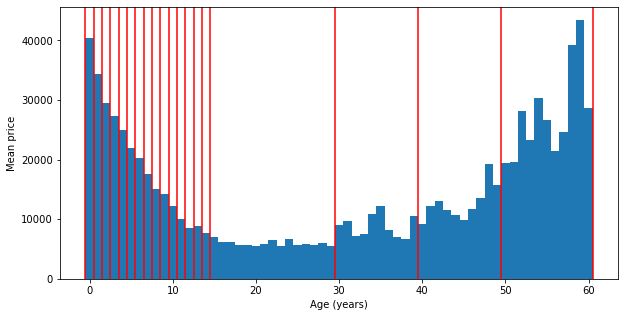

In [67]:
#we can clearly see a U-shaped pricing behavior in function of car age
#in addition, we can identify age categories with similar pricing behavior

dfAgeCat = dfAge.copy()
thresholds = [50,40,30,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]
groups = ['over 50','40-49','30-39','15-29','14','13','12','11','10','9','8','7','6','5','4','3','2','1']

x = (dfAgeCat.groupby(['age'],as_index = False).mean())['age'].tolist()
y = (dfAgeCat.groupby(['age'],as_index = False).mean())['price'].tolist()
fig = plt.figure(figsize=[10,5])
plt.ylabel('Mean price')
plt.xlabel('Age (years)')
plt.bar(x, y, width=1)
for t in thresholds:
    plt.axvline(t-0.5, color = 'red')

plt.axvline(-0.5, color = 'red')
plt.axvline(60.5, color = 'red')

In [68]:
arr = np.array(dfAgeCat['age'].tolist())
for t in thresholds:
    prevArr = arr
    arr = np.where(prevArr >= t, -t, prevArr)
    
prevArr = arr
dfAgeCat['age_group'] = np.where(prevArr >= 0, 'new', prevArr).tolist()

for i in range(len(thresholds)):
     toReplace = str(float(-thresholds[i]))
     dfAgeCat['age_group'].replace(toReplace, groups[i], inplace =  True)

dfAgeCat.drop('age', axis=1, inplace=True)    
print(dfAgeCat['age_group'].unique())
dfAgeCat

['11' '7' '15-29' '5' '9' '4' '2' '8' '1' '3' '12' '6' '10' '14' '30-39'
 '13' 'over 50' '40-49' 'new']


,price,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,car_model,age_group
0,35990,chevrolet,good,8 cylinders,gas,32742.0,other,rwd,other,unknown,al,chevrolet corvette,11
1,7500,hyundai,excellent,4 cylinders,gas,93600.0,automatic,fwd,sedan,unknown,al,hyundai sonata,7
2,4900,bmw,good,6 cylinders,gas,87046.0,automatic,4wd,SUV,blue,al,bmw x3,15-29
5,29590,toyota,good,6 cylinders,gas,33290.0,other,4wd,pickup,red,al,toyota tacoma,5
6,39990,ford,good,8 cylinders,gas,9692.0,other,rwd,coupe,blue,al,ford mustang,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
458207,19950,audi,not specified,4 cylinders,gas,101270.0,automatic,4wd,sedan,unknown,wi,audi a4,4
458208,14995,cadillac,excellent,6 cylinders,gas,83790.0,automatic,4wd,SUV,silver,wi,cadillac srx,7
458209,17895,hyundai,excellent,4 cylinders,gas,31888.0,automatic,4wd,SUV,white,wi,hyundai tucson,3
458210,17900,cadillac,excellent,6 cylinders,gas,53000.0,automatic,4wd,coupe,black,wy,cadillac cts,7


In [69]:
age_cat_metrics = updateModel(dfAgeCat)
print_metrics(age_cat_metrics)

test performance: {'r2': 77.29, 'mae': 3887.4, 'mse': 36067891.6, 'mape': 154.52}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 77.12, 'mae': 3908.81, 'mse': 36489527.62, 'mape': 158.14}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: 5.85 %


despite the fact that including 'age' decreased performance, including age categories clearly improved performance without any sign of overfitting

### Price vs features analysis

manufacturer


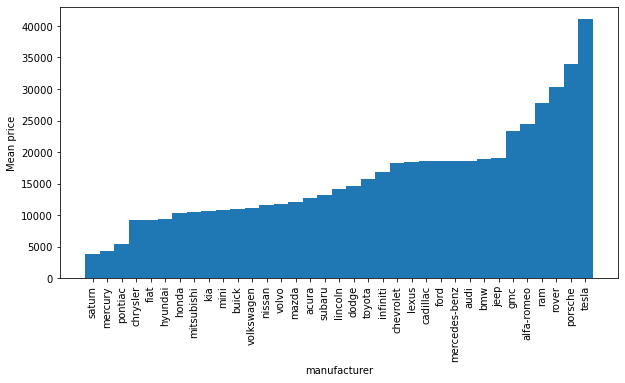

condition


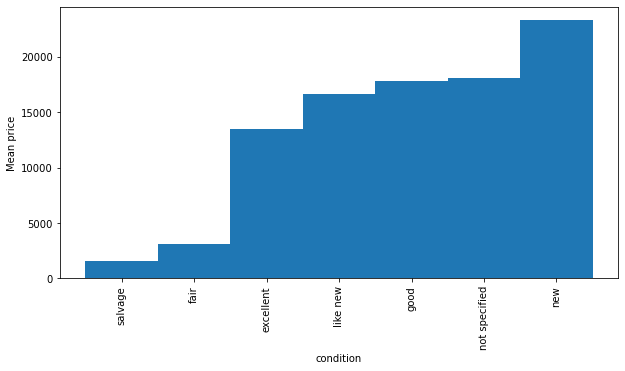

cylinders


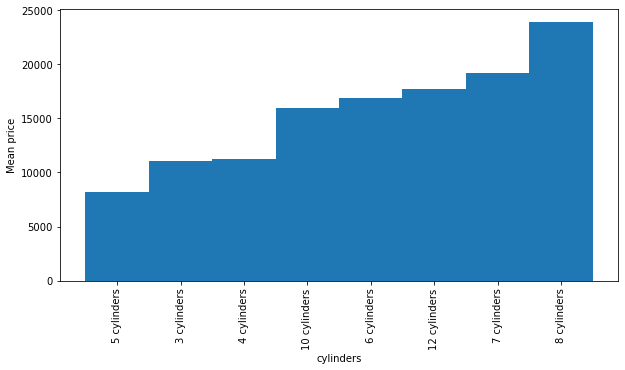

fuel


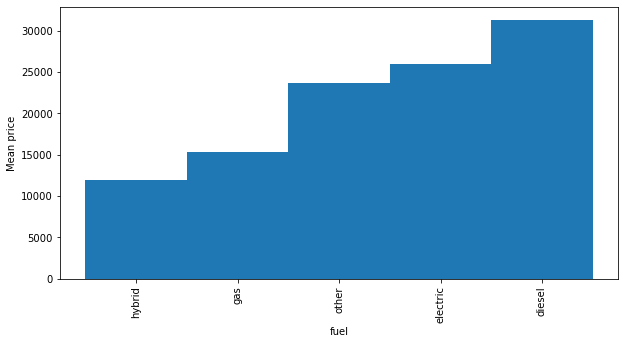

transmission


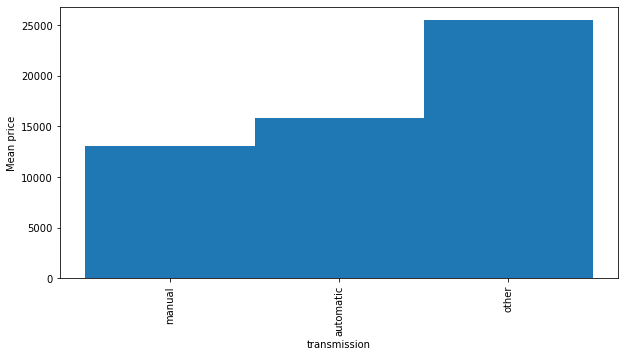

drive


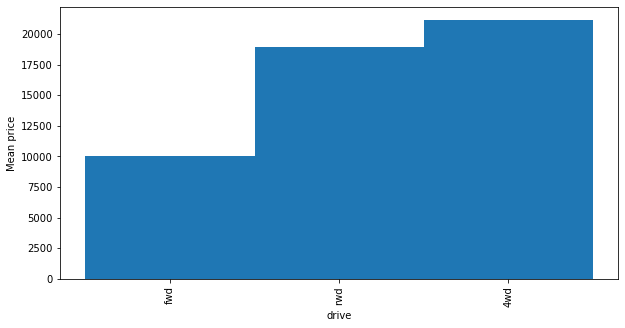

type


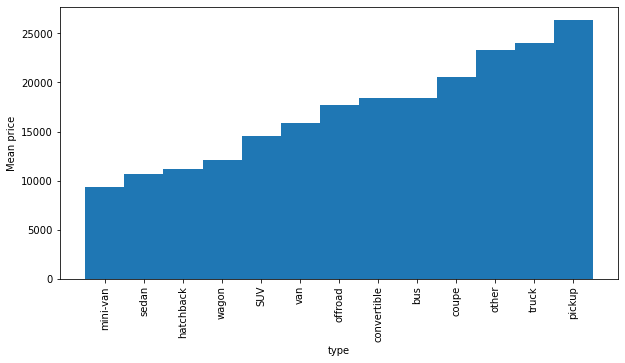

paint_color


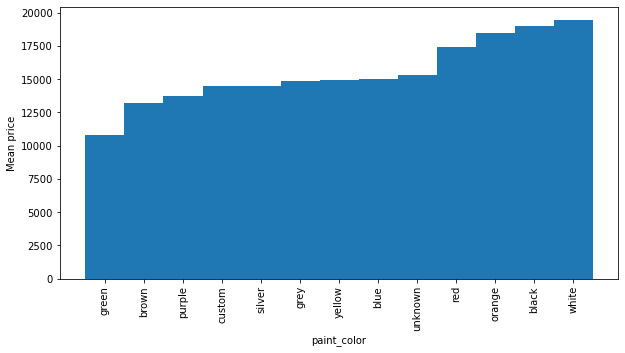

state


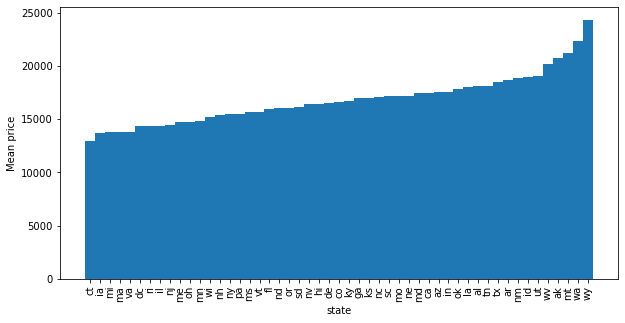

In [70]:
dfPlots = dfAge.copy()
for feat in dfAgeCat.drop(['price','odometer','car_model','age_group'], axis = 1).columns:
    print(feat)
    x = (dfPlots.groupby(feat, as_index = False).mean()).sort_values(by = ['price'])[feat]
    y = (dfPlots.groupby(feat, as_index = False).mean()).sort_values(by = ['price'])['price']
    fig = plt.figure(figsize=[10,5])
    plt.xlabel(feat)
    plt.ylabel('Mean price')
    plt.xticks(rotation = 90)
    plt.bar(x, y, width=1)
    plt.show()

### Condition as a numerical feature

In [71]:
dfCondition = df.copy()

dfCondition['condition'].replace('new', 6, inplace =  True)
dfCondition['condition'].replace('like new', 5, inplace =  True)
dfCondition['condition'].replace('excellent', 4, inplace =  True)
dfCondition['condition'].replace('good', 3, inplace =  True)
dfCondition['condition'].replace('fair', 2, inplace =  True)
dfCondition['condition'].replace('salvage', 1, inplace =  True)
dfCondition['condition'].replace('not specified', 3, inplace =  True)

dfCondition['condition'].unique()

array([3, 4, 5, 6, 1, 2], dtype=int64)

In [72]:
condition_metrics = updateModel(dfCondition)
print_metrics(condition_metrics)

test performance: {'r2': 73.82, 'mae': 4118.67, 'mse': 41580476.64, 'mape': 156.77}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 73.53, 'mae': 4125.24, 'mse': 42225121.33, 'mape': 160.32}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: 0.24 %


no significant effect on performance

### Color categories

In [73]:
dfColors = df.copy()
dfColors['paint_color'].replace(['unknown', 'blue', 'silver', 'grey', 'green', 'custom', 'yellow', 'brown', 'purple'], 'other_colors', inplace =  True)
dfColors['paint_color'].unique()

array(['other_colors', 'red', 'black', 'white', 'orange'], dtype=object)

In [74]:
color_metrics = updateModel(dfColors)
print_metrics(color_metrics)

test performance: {'r2': 73.83, 'mae': 4108.65, 'mse': 41564290.43, 'mape': 159.28}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 73.54, 'mae': 4116.97, 'mse': 42200904.37, 'mape': 162.79}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: 0.49 %


no significant effect on performance

### Miles per year

In [75]:
dfMPY = dfAge.copy()
MPY_temp = []

dfMPY['miles_per_year'] = [dfMPY['odometer'][i]/(dfMPY['age'][i]+0.001) for i in dfMPY.index.tolist()]
dfMPY.drop(['odometer', 'age'], axis=1, inplace=True)
dfMPY

,price,manufacturer,condition,cylinders,fuel,transmission,drive,type,paint_color,state,car_model,miles_per_year
0,35990,chevrolet,good,8 cylinders,gas,other,rwd,other,unknown,al,chevrolet corvette,2976.274884
1,7500,hyundai,excellent,4 cylinders,gas,automatic,fwd,sedan,unknown,al,hyundai sonata,13369.518640
2,4900,bmw,good,6 cylinders,gas,automatic,4wd,SUV,blue,al,bmw x3,5802.679821
5,29590,toyota,good,6 cylinders,gas,other,4wd,pickup,red,al,toyota tacoma,6656.668666
6,39990,ford,good,8 cylinders,gas,other,rwd,coupe,blue,al,ford mustang,1076.769248
...,...,...,...,...,...,...,...,...,...,...,...,...
458207,19950,audi,not specified,4 cylinders,gas,automatic,4wd,sedan,unknown,wi,audi a4,25311.172207
458208,14995,cadillac,excellent,6 cylinders,gas,automatic,4wd,SUV,silver,wi,cadillac srx,11968.290244
458209,17895,hyundai,excellent,4 cylinders,gas,automatic,4wd,SUV,white,wi,hyundai tucson,10625.791403
458210,17900,cadillac,excellent,6 cylinders,gas,automatic,4wd,coupe,black,wy,cadillac cts,7570.347093


In [76]:
MPY_metrics = updateModel(dfMPY)
print_metrics(MPY_metrics)

test performance: {'r2': 49.07, 'mae': 6619.22, 'mse': 80884869.81, 'mape': 162.82}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 49.39, 'mae': 6602.23, 'mse': 80719966.43, 'mape': 166.69}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: -60.32 %


significant negative impact on performance

### Excluding number of cylinders

In [77]:
dfNoCyl = df.drop('cylinders', axis = 1)
dfNoCyl

,price,year,manufacturer,condition,fuel,odometer,transmission,drive,type,paint_color,state,car_model
0,35990,2010.0,chevrolet,good,gas,32742.0,other,rwd,other,unknown,al,chevrolet corvette
1,7500,2014.0,hyundai,excellent,gas,93600.0,automatic,fwd,sedan,unknown,al,hyundai sonata
2,4900,2006.0,bmw,good,gas,87046.0,automatic,4wd,SUV,blue,al,bmw x3
5,29590,2016.0,toyota,good,gas,33290.0,other,4wd,pickup,red,al,toyota tacoma
6,39990,2012.0,ford,good,gas,9692.0,other,rwd,coupe,blue,al,ford mustang
...,...,...,...,...,...,...,...,...,...,...,...,...
458207,19950,2017.0,audi,not specified,gas,101270.0,automatic,4wd,sedan,unknown,wi,audi a4
458208,14995,2014.0,cadillac,excellent,gas,83790.0,automatic,4wd,SUV,silver,wi,cadillac srx
458209,17895,2018.0,hyundai,excellent,gas,31888.0,automatic,4wd,SUV,white,wi,hyundai tucson
458210,17900,2014.0,cadillac,excellent,gas,53000.0,automatic,4wd,coupe,black,wy,cadillac cts


In [78]:
no_cyl_metrics = updateModel(dfNoCyl)
print_metrics(no_cyl_metrics)

test performance: {'r2': 73.64, 'mae': 4147.29, 'mse': 41866124.33, 'mape': 157.07}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 73.42, 'mae': 4148.3, 'mse': 42396701.33, 'mape': 160.41}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: -0.45 %


marginal negative impact on performance

### Excluding 'type'

In [79]:
dfNoType = df.drop('type', axis = 1)
dfNoType

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,paint_color,state,car_model
0,35990,2010.0,chevrolet,good,8 cylinders,gas,32742.0,other,rwd,unknown,al,chevrolet corvette
1,7500,2014.0,hyundai,excellent,4 cylinders,gas,93600.0,automatic,fwd,unknown,al,hyundai sonata
2,4900,2006.0,bmw,good,6 cylinders,gas,87046.0,automatic,4wd,blue,al,bmw x3
5,29590,2016.0,toyota,good,6 cylinders,gas,33290.0,other,4wd,red,al,toyota tacoma
6,39990,2012.0,ford,good,8 cylinders,gas,9692.0,other,rwd,blue,al,ford mustang
...,...,...,...,...,...,...,...,...,...,...,...,...
458207,19950,2017.0,audi,not specified,4 cylinders,gas,101270.0,automatic,4wd,unknown,wi,audi a4
458208,14995,2014.0,cadillac,excellent,6 cylinders,gas,83790.0,automatic,4wd,silver,wi,cadillac srx
458209,17895,2018.0,hyundai,excellent,4 cylinders,gas,31888.0,automatic,4wd,white,wi,hyundai tucson
458210,17900,2014.0,cadillac,excellent,6 cylinders,gas,53000.0,automatic,4wd,black,wy,cadillac cts


In [80]:
no_type_metrics = updateModel(dfNoType)
print_metrics(no_type_metrics)

test performance: {'r2': 73.84, 'mae': 4123.65, 'mse': 41553778.36, 'mape': 156.8}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 73.54, 'mae': 4133.7, 'mse': 42194745.56, 'mape': 160.43}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: 0.12 %


no significant effect on performance

### Committing feature engineering changes to df

In [81]:
#only creating age_groups had a positive impact on performance
#dropping 'type' and binning 'state' into regions had no real impact on performance but made the model more interpretable

df = dfAgeCat
df = pd.merge(df, pd.DataFrame(regions_dict), on = 'state', how = 'left').drop('state', axis = 1)
df.drop('type', axis = 1, inplace = True)
df

,price,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,paint_color,car_model,age_group,region
0,35990,chevrolet,good,8 cylinders,gas,32742.0,other,rwd,unknown,chevrolet corvette,11,south
1,7500,hyundai,excellent,4 cylinders,gas,93600.0,automatic,fwd,unknown,hyundai sonata,7,south
2,4900,bmw,good,6 cylinders,gas,87046.0,automatic,4wd,blue,bmw x3,15-29,south
3,29590,toyota,good,6 cylinders,gas,33290.0,other,4wd,red,toyota tacoma,5,south
4,39990,ford,good,8 cylinders,gas,9692.0,other,rwd,blue,ford mustang,9,south
...,...,...,...,...,...,...,...,...,...,...,...,...
307417,19950,audi,not specified,4 cylinders,gas,101270.0,automatic,4wd,unknown,audi a4,4,mid-west
307418,14995,cadillac,excellent,6 cylinders,gas,83790.0,automatic,4wd,silver,cadillac srx,7,mid-west
307419,17895,hyundai,excellent,4 cylinders,gas,31888.0,automatic,4wd,white,hyundai tucson,3,mid-west
307420,17900,cadillac,excellent,6 cylinders,gas,53000.0,automatic,4wd,black,cadillac cts,7,west


## Model Creation

### Linear Regression

In [82]:
reg = LinearRegression()

In [83]:
#linear regression model on the feature engineered df

initLR = updateModel(df)
print_metrics(initLR)

test performance: {'r2': 77.04, 'mae': 3904.67, 'mse': 36464425.34, 'mape': 158.7}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 76.84, 'mae': 3926.71, 'mse': 36937814.88, 'mape': 162.29}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: 5.43 %


Feature engineering had a clear positive impact on performance without a sign of overfitting

### Feature Importance

In [84]:
cols = pd.get_dummies(df, drop_first = True).columns

In [85]:
importance = reg.coef_

temp = pd.DataFrame({'feat n°': [x for x in range(len(importance))],'importance': importance})
temp = temp.sort_values('importance')
worst10 = temp[:10]
best10 = temp[-10:]
best10['feat'] = cols[best10['feat n°']]
worst10['feat'] = cols[worst10['feat n°']]

<ipython-input-85-49b02853c5f0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best10['feat'] = cols[best10['feat n°']]
<ipython-input-85-49b02853c5f0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worst10['feat'] = cols[worst10['feat n°']]


<BarContainer object of 10 artists>

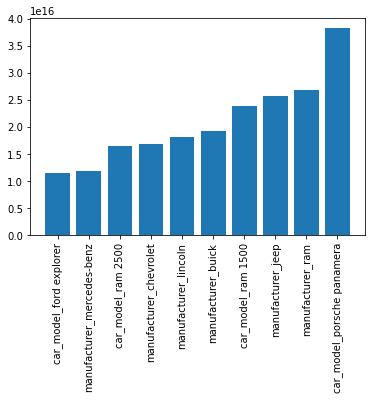

In [86]:
plt.xticks(rotation = 90)
plt.bar(best10['feat'], best10['importance'])

<BarContainer object of 10 artists>

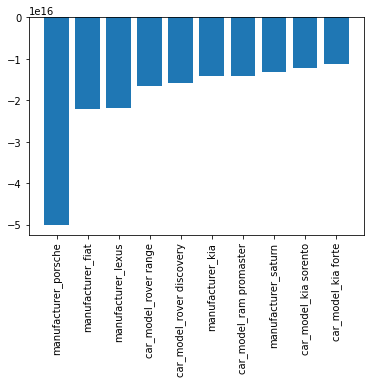

In [87]:
plt.xticks(rotation = 90)
plt.bar(worst10['feat'], worst10['importance'])

### Random Forest Regressor

In [88]:
#20-tree RF

reg = RandomForestRegressor(n_estimators = 20, random_state = 7)

In [89]:
initRF = updateModel(df)
print_metrics(initRF)

test performance: {'r2': 91.06, 'mae': 1690.99, 'mse': 14200739.7, 'mape': 73.87}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 98.12, 'mae': 690.12, 'mse': 2999876.55, 'mape': 30.71}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: 59.04 %


In [90]:
kcv = get_kCVscores(df)
kcv

array([2606.41436838, 2274.70038815, 2038.59093853, 2329.32652851,
       2444.175114  ])

In [75]:
print('Cross validated MAE mean:', kcv.mean())
print('Cross validated MAE standard deviation:', kcv.std())

NameError: name 'kcv' is not defined

In [76]:
#100-tree RF

reg = RandomForestRegressor(n_estimators = 100, random_state = 7)

In [77]:
init100RF = updateModel(df)
print_metrics(init100RF)

NameError: name 'df' is not defined

the 20-tree random forest drastically outperforms the linear regression

however, cross validation clearly signals an overfitting problem

### Boosted Tree Regressor

In [78]:
reg = GradientBoostingRegressor(n_estimators = 50, learning_rate = 0.1, max_depth = 1, random_state = 7, loss = 'ls')

In [79]:
initBoost = updateModel(df)
print_metrics(initBoost)

NameError: name 'df' is not defined

Boosted Tree performs significantly worse than linear regression

### Neural Network

In [80]:
reg = MLPRegressor()

In [81]:
initNN = updateModel(df)
print_metrics(initNN)

NameError: name 'df' is not defined

Better than LR but not better than RF

### Clustering

In [82]:
#Elbow plot values
distortions = []
df_with_dummies = pd.get_dummies(df.copy(), drop_first = True)

K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(df_with_dummies)
    distortions.append(km.inertia_)

#Plotting
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method to determine the optimal k value')
plt.show()

NameError: name 'df' is not defined

In [91]:
df_clustering_k2 = k_means_clustering(df, 2)
df_clustering_k2

,price,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,paint_color,car_model,age_group,region,cluster
0,35990,chevrolet,good,8 cylinders,gas,32742.0,other,rwd,unknown,chevrolet corvette,11,south,0
1,7500,hyundai,excellent,4 cylinders,gas,93600.0,automatic,fwd,unknown,hyundai sonata,7,south,0
2,4900,bmw,good,6 cylinders,gas,87046.0,automatic,4wd,blue,bmw x3,15-29,south,0
3,29590,toyota,good,6 cylinders,gas,33290.0,other,4wd,red,toyota tacoma,5,south,0
4,39990,ford,good,8 cylinders,gas,9692.0,other,rwd,blue,ford mustang,9,south,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307417,19950,audi,not specified,4 cylinders,gas,101270.0,automatic,4wd,unknown,audi a4,4,mid-west,1
307418,14995,cadillac,excellent,6 cylinders,gas,83790.0,automatic,4wd,silver,cadillac srx,7,mid-west,0
307419,17895,hyundai,excellent,4 cylinders,gas,31888.0,automatic,4wd,white,hyundai tucson,3,mid-west,0
307420,17900,cadillac,excellent,6 cylinders,gas,53000.0,automatic,4wd,black,cadillac cts,7,west,0


In [84]:
df_clustering_k3 = k_means_clustering(df, 3)
df_clustering_k3

NameError: name 'df' is not defined

In [85]:
pd.get_dummies(df_clustering_k2, drop_first = True).groupby(['cluster']).median()

NameError: name 'df_clustering_k2' is not defined

interpretation: cluster 0 are more expensive cars with low mileage while cluster 1 are cheap cars with a lot of mileage

In [86]:
pd.get_dummies(df_clustering_k3, drop_first = True).groupby(['cluster']).median()

NameError: name 'df_clustering_k3' is not defined

interpretation: analogous but with an extra 'medium priced' category

In [87]:
reg = LinearRegression()

In [88]:
df_to_use = pd.get_dummies(df_clustering_k2, drop_first = True)
k = 2
print('For k = ', k)

list_of_results = []
for i in range(k):
    cluster_df = (df_to_use[df_to_use['cluster']==i]).copy()
    res = updateModel(cluster_df)
    print_metrics(res)
    list_of_results.append(res)

clust_k2_LR_results = list_of_results

NameError: name 'df_clustering_k2' is not defined

In [89]:
df_to_use = pd.get_dummies(df_clustering_k3, drop_first = True)
k = 3
print('For k = ', k)

list_of_results = []
for i in range(k):
    cluster_df = (df_to_use[df_to_use['cluster']==i]).copy()
    res = updateModel(cluster_df)
    print_metrics(res)
    list_of_results.append(res)

clust_k3_LR_results = list_of_results

NameError: name 'df_clustering_k3' is not defined

K=2 seems to improve performance the most and the clusters are also more interpretable

In [94]:
reg = RandomForestRegressor(n_estimators = 20, random_state = 7)

In [95]:
df_to_use = pd.get_dummies(df_clustering_k2, drop_first = True)
k = 2
print('For k = ', k)

list_of_results = []
for i in range(k):
    cluster_df = (df_to_use[df_to_use['cluster']==i]).copy()
    res = updateModel(cluster_df)
    print_metrics(res)
    list_of_results.append(res)

clust_k2_RF_results = list_of_results

For k =  2
test performance: {'r2': 87.52, 'mae': 2032.83, 'mse': 21208153.68, 'mape': 104.53}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 97.41, 'mae': 830.22, 'mse': 4413907.39, 'mape': 40.07}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: 50.76 %
test performance: {'r2': 89.84, 'mae': 1306.41, 'mse': 6379895.79, 'mape': 46.43}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 97.86, 'mae': 525.53, 'mse': 1327007.07, 'mape': 19.41}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: 68.36 %


In [92]:
print_metrics(initRF)

NameError: name 'print_metrics' is not defined

### Final Model

In [92]:
dfFinal = df_clustering_k2.copy()
dfFinal

,price,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,paint_color,car_model,age_group,region,cluster
0,35990,chevrolet,good,8 cylinders,gas,32742.0,other,rwd,unknown,chevrolet corvette,11,south,0
1,7500,hyundai,excellent,4 cylinders,gas,93600.0,automatic,fwd,unknown,hyundai sonata,7,south,0
2,4900,bmw,good,6 cylinders,gas,87046.0,automatic,4wd,blue,bmw x3,15-29,south,0
3,29590,toyota,good,6 cylinders,gas,33290.0,other,4wd,red,toyota tacoma,5,south,0
4,39990,ford,good,8 cylinders,gas,9692.0,other,rwd,blue,ford mustang,9,south,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307417,19950,audi,not specified,4 cylinders,gas,101270.0,automatic,4wd,unknown,audi a4,4,mid-west,1
307418,14995,cadillac,excellent,6 cylinders,gas,83790.0,automatic,4wd,silver,cadillac srx,7,mid-west,0
307419,17895,hyundai,excellent,4 cylinders,gas,31888.0,automatic,4wd,white,hyundai tucson,3,mid-west,0
307420,17900,cadillac,excellent,6 cylinders,gas,53000.0,automatic,4wd,black,cadillac cts,7,west,0


In [96]:
finalPerformance = clust_k2_RF_results
print('Cluster 1:')
print_metrics(finalPerformance[0])
print()
print('Cluster 2:')
print_metrics(finalPerformance[1])

Cluster 1:
test performance: {'r2': 87.52, 'mae': 2032.83, 'mse': 21208153.68, 'mape': 104.53}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 97.41, 'mae': 830.22, 'mse': 4413907.39, 'mape': 40.07}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: 50.76 %

Cluster 2:
test performance: {'r2': 89.84, 'mae': 1306.41, 'mse': 6379895.79, 'mape': 46.43}
initial test performance: {'r2': 73.95, 'mae': 4128.78, 'mse': 41380776.7, 'mape': 156.12}

train performance: {'r2': 97.86, 'mae': 525.53, 'mse': 1327007.07, 'mape': 19.41}
initial train performance: {'r2': 73.64, 'mae': 4138.43, 'mse': 42034353.94, 'mape': 159.79}

change in test MAE: 68.36 %


In [108]:
X = cluster_df.drop('price', axis = 1)
y = cluster_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True) 

print(X_train)

        odometer  cluster  manufacturer_alfa-romeo  manufacturer_audi  \
231046  165200.0        1                        0                  0   
291112  175410.0        1                        0                  0   
51108   142092.0        1                        0                  0   
141737  114296.0        1                        0                  0   
44812   129130.0        1                        0                  0   
...          ...      ...                      ...                ...   
241163  100025.0        1                        0                  0   
263135  165000.0        1                        0                  0   
227761  161500.0        1                        0                  0   
289413  138387.0        1                        0                  0   
267388  178000.0        1                        0                  0   

        manufacturer_bmw  manufacturer_buick  manufacturer_cadillac  \
231046                 0                   0        

In [98]:
finalModel = reg
reg

RandomForestRegressor(n_estimators=20, random_state=7)

In [99]:
finalClusters = df_clustering_k2.copy()
pd.get_dummies(finalClusters, drop_first = True).groupby(['cluster']).median()

,price,odometer,manufacturer_alfa-romeo,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_dodge,...,age_group_5,age_group_6,age_group_7,age_group_8,age_group_9,age_group_new,age_group_over 50,region_north-east,region_south,region_west
cluster,,,,,,,,,,,,,,,,,,,,,
0,19990,46186.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7495,140000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
dfFinal.to_csv('final.csv')